In [1]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from module import MLP3, Train, EWC, evaluate, permute_task

%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [2]:
epochs = 100
lambda_ = 0.1 
lr = 0.001
num_sample = 30
opt = tf.keras.optimizers.Adam(learning_rate=lr)
loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

**Task Preparation**

In [3]:
(x_train_A, y_train_A), (x_test_A, y_test_A) = mnist.load_data()
x_train_A = x_train_A.astype('float32')
x_test_A = x_test_A.astype('float32')
x_train_A /= 255
x_test_A /= 255

train_A = tf.data.Dataset.from_tensor_slices((x_train_A, y_train_A)).shuffle(1000).batch(32)
test_A = (x_test_A, y_test_A)

x_train_B, x_test_B = permute_task(x_train_A, x_test_A)
y_train_B, y_test_B = y_train_A, y_test_A

train_B = tf.data.Dataset.from_tensor_slices((x_train_B, y_train_B)).shuffle(1000).batch(32)
test_B = (x_test_B, y_test_B)

**Display sample data points**

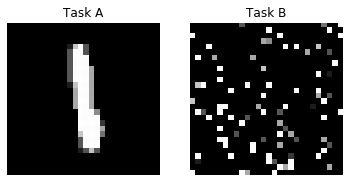

In [4]:
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(x_train_A[200], cmap='gray')
plt.title('Task A')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(x_train_B[200], cmap='gray')
plt.title('Task B')
plt.axis('off')
plt.show()

**Create a model object**

In [5]:
mlp = MLP3()

**GD Training of Task - A**

In [6]:
trn_gd = Train(opt, loss_fn)
model = mlp.get_compiled_model(opt, loss_fn, ['accuracy'])

acc_prior_A = trn_gd.train(model, epochs, train_A, test_tasks=[test_A])[0]
model.save('MNIST_A.h5')
print('[INFO] Task A Original (SGD): {}'.format(acc_prior_A[-1]))

  0%|          | 0/100 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Num'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Num'


100%|██████████| 100/100 [48:22<00:00, 29.03s/it]

[INFO] Task A Original (SGD): 98.28


**Fisher matrix computation using the weights obtained from training task A to criterion**

In [7]:
# construct the fisher matrix using samples from task A
ewc = EWC(model, x_train_A, num_sample=num_sample)
f_matrix = ewc.get_fisher()

100%|██████████| 30/30 [00:00<00:00, 261.46it/s]


**Training task B with EWC - using the computed Fisher matrix from task A and the prior weights obtained from A**

In [8]:
model_ewcB = mlp.get_compiled_model(opt, loss_fn, ['accuracy'])
model_ewcB.load_weights('MNIST_A.h5')
prior_weights = model_ewcB.get_weights()

In [9]:
trn = Train(opt, loss_fn, prior_weights=prior_weights, lambda_=lambda_)
acc_ewcA, acc_ewcB = trn.train(model_ewcB, 
                     epochs, 
                     train_B, 
                     fisher_matrix=f_matrix, 
                     test_tasks=[test_A, test_B]
                    )

print('[INFO] Task A ACC. after training B with EWC: {}'.format(acc_ewcA[-1]))
print('[INFO] Task B ACC. after training B with EWC: {}'.format(acc_ewcB[-1]))

100%|██████████| 100/100 [1:38:09<00:00, 58.89s/it]

[INFO] Task A ACC. after training B with EWC: 96.07
[INFO] Task B ACC. after training B with EWC: 97.72


**Training task B with vannila SGD**

In [10]:
model_sgdB = mlp.get_compiled_model(opt, loss_fn, ['accuracy'])
model_sgdB.load_weights('MNIST_A.h5')
acc_sgdA, acc_sgdB = trn_gd.train(model_sgdB, epochs, train_B, test_tasks = [test_A, test_B])

print('[INFO] Task A ACC. after training B with GD: {}'.format(acc_sgdA[-1]))
print('[INFO] Task B ACC. after training B with GD: {}'.format(acc_sgdB[-1]))

100%|██████████| 100/100 [1:15:24<00:00, 45.24s/it]

[INFO] Task A ACC. after training B with GD: 70.53
[INFO] Task B ACC. after training B with GD: 97.82


**Bar plots**

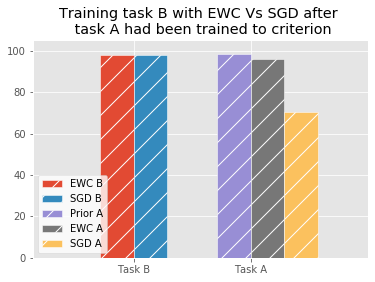

In [11]:
x = 0
total_width, n = 0.1, 2
width = total_width / n
x = x - (total_width - width) / 2
plt.style.use('ggplot')
plt.bar(x, acc_ewcB[-1], width=width, label='EWC B', hatch='w/', ec='w')
plt.bar(x + width, acc_sgdB[-1], width=width, label='SGD B', hatch='w/', ec='w')
plt.bar(x + 3.5 * width, acc_prior_A[-1], width=width, label='Prior A', hatch='w/', ec='w')
plt.bar(x + 4.5 * width, acc_ewcA[-1], width=width, label='EWC A', hatch='w/', ec='w')
plt.bar(x + 5.5 * width, acc_sgdA[-1], width=width, label='SGD A', hatch='w/', ec='w')
plt.legend(facecolor='white', loc='lower left')
plt.xticks(np.array([0., 3.5 * width]), ('Task B', 'Task A'))
plt.title('Training task B with EWC Vs SGD after \n task A had been trained to criterion')
plt.xlim(-0.15, 0.35)
plt.ylim(0., 105.)
plt.show()

**Line plots**

Text(0.5, 0, 'Epochs')

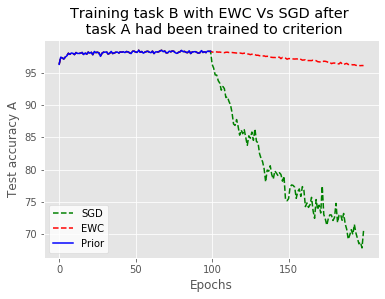

In [14]:

plt.plot(range(0, epochs*2, 1), (acc_prior_A + acc_sgdA), color='green', linestyle='dashed', label = "SGD")
plt.plot(range(0, epochs*2, 1), (acc_prior_A + acc_ewcA), color='red', linestyle='dashed', label = "EWC")
plt.plot(range(0, epochs, 1), (acc_prior_A), color='blue', label = "Prior")
#plt.axvline(x=9, linestyle='dashed', color='green')
plt.xticks(range(0, epochs*2, 50))
plt.title('Training task B with EWC Vs SGD after \n task A had been trained to criterion')
plt.legend(facecolor='white')
plt.ylabel('Test accuracy A')
plt.xlabel('Epochs')